In [2]:
#Importing Libraries

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/Auto-Colorization-Of-GrayScale-Image/
%ls

/content/drive/MyDrive/Auto-Colorization-Of-GrayScale-Image
Auto_color.ipynb  model.h5    README.md  Screenshots/
Dataset/          model.json  result/


In [8]:
#Getting Images

X = []
for imagename in os.listdir('Dataset/Train/'):
    X.append(img_to_array(load_img('Dataset/Train/'+imagename)))
X = np.array(X, dtype=float)


# Set up train and test data

split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

In [9]:
#CNN model

from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Sequential

model = Sequential()

#Input Layer
model.add(Conv2D(64, (3, 3), input_shape=(256, 256, 1), activation='relu', padding='same'))

#Hidden Layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

#Compiling the CNN
model.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])

In [10]:
import matplotlib.pyplot as plt

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model      
tensorboard = TensorBoard(log_dir="/output/beta_run")
trainedmodel = model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard],epochs=500, steps_per_epoch=30)

<ipython-input-10-4b13a41f0cc9>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  trainedmodel = model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard],epochs=500, steps_per_epoch=30)


Epoch 1/500
30/30 [==============================] - 25s 288ms/step - loss: 0.0707 - accuracy: 0.5424
Epoch 2/500
30/30 [==============================] - 8s 253ms/step - loss: 0.0107 - accuracy: 0.5555
Epoch 3/500
30/30 [==============================] - 12s 422ms/step - loss: 0.0095 - accuracy: 0.6005
Epoch 4/500
30/30 [==============================] - 14s 472ms/step - loss: 0.0095 - accuracy: 0.6048
Epoch 5/500
30/30 [==============================] - 9s 297ms/step - loss: 0.0109 - accuracy: 0.5191
Epoch 6/500
30/30 [==============================] - 8s 251ms/step - loss: 0.0096 - accuracy: 0.5807
Epoch 7/500
30/30 [==============================] - 9s 295ms/step - loss: 0.0107 - accuracy: 0.5779
Epoch 8/500
30/30 [==============================] - 8s 279ms/step - loss: 0.0101 - accuracy: 0.5927
Epoch 9/500
30/30 [==============================] - 10s 325ms/step - loss: 0.0106 - accuracy: 0.5664
Epoch 10/500
30/30 [==============================] - 9s 297ms/step - loss: 0.0093 - ac

KeyError: ignored

In [12]:
trainedmodel.history.keys()

dict_keys(['loss', 'accuracy'])

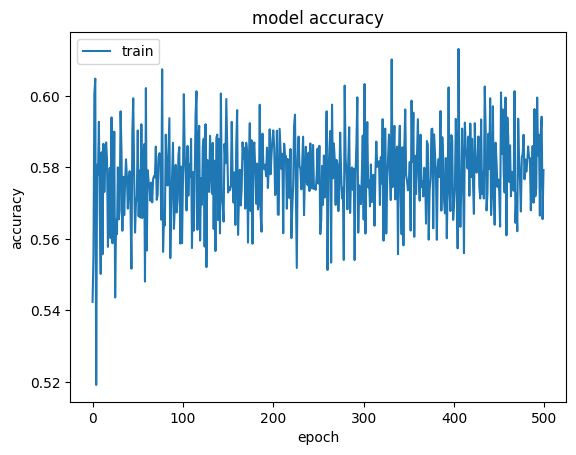

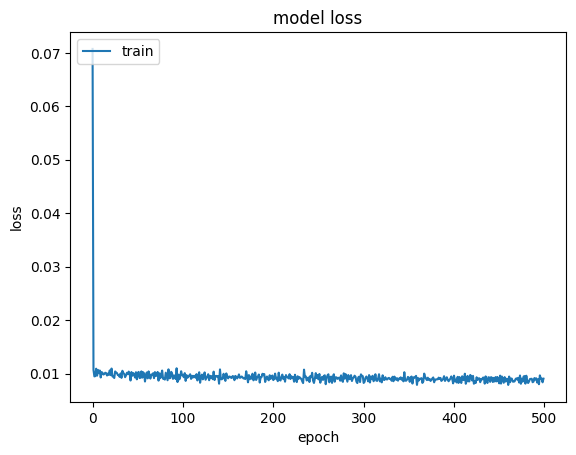

In [27]:
# summarize history for accuracy
plt.plot(trainedmodel.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(trainedmodel.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
# Save model

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [29]:
# load json and create model

from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [30]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 512)       1

In [31]:
# Test images

loaded_model.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])

Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(loaded_model.evaluate(Xtest, Ytest, batch_size=32))

2/2 [==============================] - 0s 48ms/step - loss: 0.0089 - accuracy: 0.5708
[0.008876334875822067, 0.5708004236221313]


Output of the Model
1/1 [==============================] - 0s 30ms/step


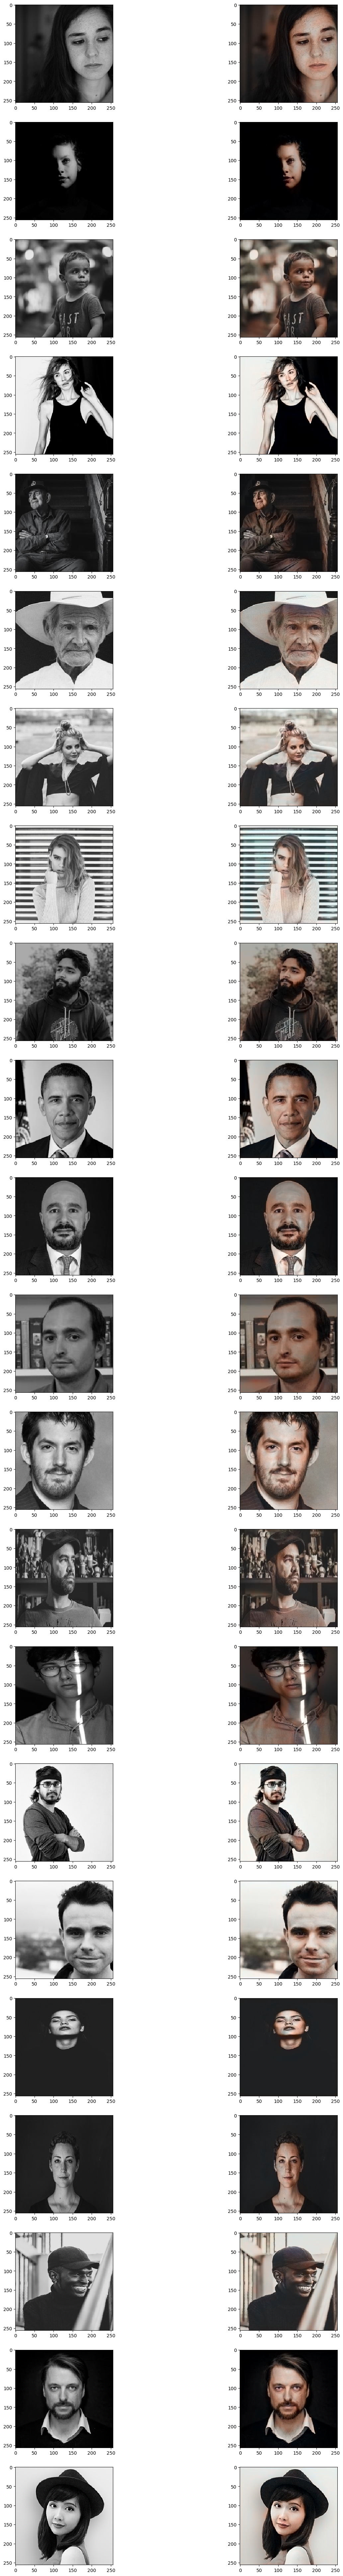

In [38]:
# Manual Testing of Images

import cv2
import os
%matplotlib inline 
from matplotlib import pyplot as plt

fig, ax = plt.subplots(22, 2, figsize=(16,100))
row = 0
colorize = []
print('Output of the Model')
for filename in os.listdir('Dataset/Test/'):
	if filename != '.ipynb_checkpoints':
		colorize.append(img_to_array(load_img('Dataset/Test/'+filename)))
		ax[row,0].imshow(load_img('Dataset/Test/'+filename), interpolation='nearest')
		row +=1

colorize = np.array(colorize, dtype=float)
colorize = rgb2lab(1.0/255*colorize)[:,:,:,0]
colorize = colorize.reshape(colorize.shape+(1,))


# Test model
output = loaded_model.predict(colorize)
output = output * 128

row = 0

# Output colorizations
for i in range(len(output)):
	cur = np.zeros((256, 256, 3))
	cur[:,:,0] = colorize[i][:,:,0]
	cur[:,:,1:] = output[i]
	resImage = lab2rgb(cur)
	ax[row,1].imshow(resImage, interpolation='nearest')
	row +=1
    

# 	imsave("result/img_"+str(i)+".png", resImage)
    
    